In [1]:
conda --version

conda 4.8.3

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pymoo

  Created wheel for autograd: filename=autograd-1.3-py3-none-any.whl size=47994 sha256=40140a1237a0a29e19c54056511d131d1bf0546d1944c1236710fc5968026bf4
  Stored in directory: c:\users\blove\appdata\local\pip\cache\wheels\ef\32\31\0e87227cd0ca1d99ad51fbe4b54c6fa02afccf7e483d045e04
Successfully built autograd
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pymoo

In [3]:
conda create -n pymoo -y python==3.7 numpy

^C

Note: you may need to restart the kernel to use updated packages.


In [4]:
conda update -n base -c defaults conda

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [5]:
conda activate pymoo


Note: you may need to restart the kernel to use updated packages.


python -c "from pymoo.util.function_loader import is_compiled;print('Compiled Extensions: ', is_compiled())"

In [7]:
make compile

SyntaxError: invalid syntax (<ipython-input-7-3a56e0662134>, line 1)

# Algorithms
## NSGA2

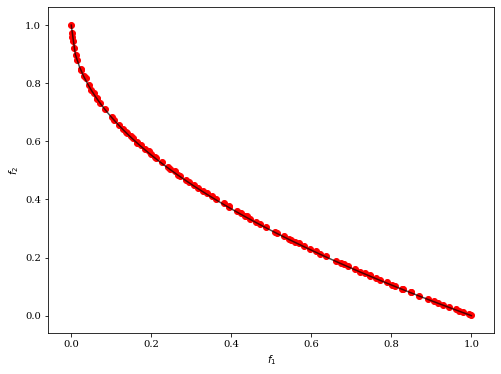

In [8]:
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

problem = get_problem("zdt1")

algorithm = NSGA2(pop_size=100)

res = minimize(problem,
               algorithm,
               ('n_gen', 200),
               seed=1,
               verbose=False)

plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, color="red")
plot.show()

## ZDT1

In [9]:
from pymoo.factory import get_problem

zdt1 = get_problem("zdt1")

# Example Problem
### Define Problem

In [10]:
import numpy as np
from pymoo.util.misc import stack
from pymoo.model.problem import Problem

class MyProblem(Problem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=2,
                         n_constr=2,
                         xl=np.array([-2,-2]),
                         xu=np.array([2,2]))

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:,0]**2 + x[:,1]**2
        f2 = (x[:,0]-1)**2 + x[:,1]**2

        g1 = 2*(x[:, 0]-0.1) * (x[:, 0]-0.9) / 0.18
        g2 = - 20*(x[:, 0]-0.4) * (x[:, 0]-0.6) / 4.8

        out["F"] = np.column_stack([f1, f2])
        out["G"] = np.column_stack([g1, g2])


    # --------------------------------------------------
    # Pareto-front - not necessary but used for plotting
    # --------------------------------------------------
    def _calc_pareto_front(self, flatten=True, **kwargs):
        f1_a = np.linspace(0.1**2, 0.4**2, 100)
        f2_a = (np.sqrt(f1_a) - 1)**2

        f1_b = np.linspace(0.6**2, 0.9**2, 100)
        f2_b = (np.sqrt(f1_b) - 1)**2

        a, b = np.column_stack([f1_a, f2_a]), np.column_stack([f1_b, f2_b])
        return stack(a, b, flatten=flatten)

    # --------------------------------------------------
    # Pareto-set - not necessary but used for plotting
    # --------------------------------------------------
    def _calc_pareto_set(self, flatten=True, **kwargs):
        x1_a = np.linspace(0.1, 0.4, 50)
        x1_b = np.linspace(0.6, 0.9, 50)
        x2 = np.zeros(50)

        a, b = np.column_stack([x1_a, x2]), np.column_stack([x1_b, x2])
        return stack(a,b, flatten=flatten)

problem = MyProblem()

### Initialize Algorithm

In [11]:
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=20),
    eliminate_duplicates=True
)

### Define a Termination Criterion
Instead of number of generations (or iterations) other criteria such as the number of function evaluations or the improvement in design or objective space from the last to the current generation can be used.

In [12]:
from pymoo.factory import get_termination

termination = get_termination("n_gen", 40)

### Solve Problem

In [24]:
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               pf=problem.pareto_front(use_cache=False),
               save_history=True,
               verbose=False)

### Visualize

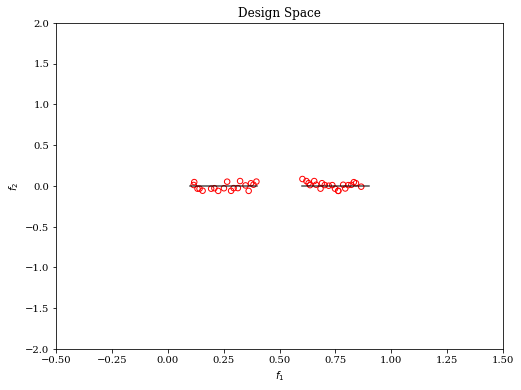

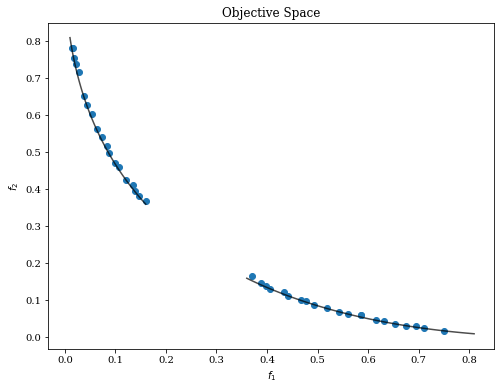

In [14]:
from pymoo.visualization.scatter import Scatter

# get the pareto-set and pareto-front for plotting
ps = problem.pareto_set(use_cache=False, flatten=False)
pf = problem.pareto_front(use_cache=False, flatten=False)

# Design Space
plot = Scatter(title = "Design Space", axis_labels="x")
plot.add(res.X, s=30, facecolors='none', edgecolors='r')
plot.add(ps, plot_type="line", color="black", alpha=0.7)
plot.do()
plot.apply(lambda ax: ax.set_xlim(-0.5, 1.5))
plot.apply(lambda ax: ax.set_ylim(-2, 2))
plot.show()

# Objective Space
plot = Scatter(title = "Objective Space")
plot.add(res.F)
plot.add(pf, plot_type="line", color="black", alpha=0.7)
plot.show()

## Performance Tracking

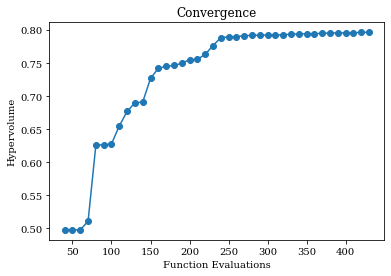

In [15]:
import matplotlib.pyplot as plt
from pymoo.performance_indicator.hv import Hypervolume

# create the performance indicator object with reference point (4,4)
metric = Hypervolume(ref_point=np.array([1.0, 1.0]))

# collect the population in each generation
pop_each_gen = [a.pop for a in res.history]

# receive the population in each generation
obj_and_feasible_each_gen = [pop[pop.get("feasible")[:,0]].get("F") for pop in pop_each_gen]

# calculate for each generation the HV metric
hv = [metric.calc(f) for f in obj_and_feasible_each_gen]

# function evaluations at each snapshot
n_evals = np.array([a.evaluator.n_eval for a in res.history])

# visualze the convergence curve
plt.plot(n_evals, hv, '-o')
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()

# Interface
## Interface: Minimize 

In [16]:
def minimize(problem,
             algorithm,
             termination=None,
             seed=None,
             verbose=False,
             display=None,
             callback=None,
             return_least_infeasible=False,
             save_history=False
             )

SyntaxError: invalid syntax (<ipython-input-16-18e1aeaadcd5>, line 10)

seed: Most algorithms underly some randomness. Setting the seed to a positive integer value ensure reproducible results. If not provided a random seed will be set automatically and the used integer will be stored in the Result object.

return_least_infeasible: Whether if the algorithm can not find a feasible solution the least infeasible solution should be returned. By default False.

## Interface: Termination Criteria

In [ ]:
from pymoo.util.termination.default import MultiObjectiveDefaultTermination

termination = MultiObjectiveDefaultTermination(
    x_tol=1e-8,
    cv_tol=1e-6,
    f_tol=0.0025,
    nth_gen=5,
    n_last=30,
    n_max_gen=1000,
    n_max_evals=100000
)

tol: What is the tolerance in the objective space in average. If the value is below this bound we terminate.

n_last: To make the criterion more robust, we consider the last n generations and take the maximum. This considers the worst case in a window.

n_max_gen: As a fallback the generation number can be used. For some problems the termination criterion might not be reached, however, an upper bound for generations can be defined to stop in that case.

nth_gen: Defines whenever the termination criterion is calculated. By default, every 10th generation.

## Interface: Callback

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from pymoo.algorithms.so_genetic_algorithm import GA
from pymoo.factory import get_problem
from pymoo.model.callback import Callback
from pymoo.optimize import minimize


class MyCallback(Callback):

    def __init__(self) -> None:
        super().__init__()
        self.data["best"] = []

    def notify(self, algorithm):
        self.data["best"].append(algorithm.pop.get("F").min())


problem = get_problem("sphere")

algorithm = GA(pop_size=100)

res = minimize(problem,
               algorithm,
               ('n_gen', 20),
               seed=1,
               callback=MyCallback(),
               save_history=True,
               verbose=True)

val = res.algorithm.callback.data["best"]
plt.plot(np.arange(len(val)), val)
plt.show()

By using the history object the same as above can be achieved by using the stored information during the run:

In [ ]:
val = [e.pop.get("F").min() for e in res.history]
plt.plot(np.arange(len(val)), val)
plt.show()

## Interface: Display
To change what is displayed for each gen pass display object to minimize function. 

In [ ]:
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_problem
from pymoo.optimize import minimize
from pymoo.util.display import Display
import numpy as np


class MyDisplay(Display):

    def _do(self, problem, evaluator, algorithm):
        super()._do(problem, evaluator, algorithm)
        self.output.append("metric_a", np.mean(algorithm.pop.get("X")))
        self.output.append("metric_b", np.mean(algorithm.pop.get("F")))


problem = get_problem("zdt2")

algorithm = NSGA2(pop_size=100)

res = minimize(problem,
               algorithm,
               ('n_gen', 10),
               seed=1,
               display=MyDisplay(),
               verbose=True)

to add more columns see website

## Interface: Results 

res.X - design space values are

res.F - objective spaces values

res.G - constraint values

res.CV - aggregated constraint violation

res.algorithm - algorithm object

res.pop - final population object

res.history - history of algorithm object. (only if save_history has been enabled during the algorithm initialization)

res.time - the time required to run the algorithm

In [28]:
from pymoo.algorithms.so_genetic_algorithm import GA
from pymoo.factory import get_problem
from pymoo.optimize import minimize


problem = get_problem("sphere")
algorithm = GA(pop_size=5)
res = minimize(problem,
               algorithm,
               ('n_gen', 30),
               seed=1)

In [29]:
res.X, res.F, res.G, res.CV

(array([0.38401994, 0.51096839, 0.51958345, 0.50705362, 0.64625327,
        0.52972181, 0.51346167, 0.57393803, 0.48975355, 0.49213286]),
 array([0.04209328]),
 None,
 array([0.]))

In [30]:
res.algorithm, res.pop

(<pymoo.algorithms.so_genetic_algorithm.GA at 0x1469aee2a08>,
 Population([<pymoo.model.individual.Individual object at 0x000001469ABEDE88>,
            dtype=object))

In [31]:
res.pop.get("X"), res.pop.get("F")

(array([[0.38401994, 0.51096839, 0.51958345, 0.50705362, 0.64625327,
         0.52972181, 0.51346167, 0.57393803, 0.48975355, 0.49213286],
        [0.38401994, 0.51096839, 0.51958345, 0.50705362, 0.64625327,
         0.52972181, 0.51346167, 0.57393803, 0.51785226, 0.49213286],
        [0.38401994, 0.51099826, 0.44223106, 0.50705362, 0.64625327,
         0.52808581, 0.51346167, 0.57393803, 0.39462856, 0.49213286],
        [0.38401994, 0.51099826, 0.44223106, 0.50705362, 0.64625327,
         0.52864113, 0.51346167, 0.57393803, 0.39462856, 0.49213286],
        [0.38401994, 0.47389685, 0.44223106, 0.50705362, 0.64625327,
         0.52808581, 0.51346167, 0.57393803, 0.39462856, 0.49213286]]),
 array([[0.04209328],
        [0.04230699],
        [0.05595125],
        [0.05598275],
        [0.05651167]]))

Problem with constraints

In [32]:
problem = get_problem("g01")
algorithm = GA(pop_size=5)
res = minimize(problem,
               algorithm,
               ('n_gen', 5),
               verbose=True,
               seed=1)

n_gen |  n_eval |   cv (min)   |   cv (avg)   |     fopt     |     favg    
    1 |       5 |  1.35027E+02 |  5.47570E+02 |            - |            -
    2 |      10 |  1.35027E+02 |  3.16525E+02 |            - |            -
    3 |      15 |  1.35027E+02 |  2.16131E+02 |            - |            -
    4 |      20 |  1.35027E+02 |  1.60240E+02 |            - |            -
    5 |      25 |  1.33435E+02 |  1.38575E+02 |            - |            -


In [33]:
res.X, res.F, res.G, res.CV

(None, None, None, None)

None return means no feasible solution found

Multi-objective example:

In [35]:
from pymoo.algorithms.nsga2 import NSGA2

problem = get_problem("zdt2")
algorithm = NSGA2()
res = minimize(problem,
               algorithm,
               ('n_gen', 10),
               seed=1)

In [36]:
res.F

array([[4.02723032e-01, 2.92285190e+00],
       [2.42936792e-03, 3.09049957e+00],
       [6.42640810e-05, 3.80452248e+00],
       [9.03843390e-02, 2.97779402e+00],
       [7.51601609e-04, 3.12489259e+00],
       [2.66638116e-05, 4.15122904e+00],
       [5.32367109e-01, 2.91333135e+00],
       [7.51074119e-05, 3.17766175e+00],
       [9.96726161e-01, 2.73633323e+00],
       [9.37668137e-01, 2.76323527e+00],
       [2.78148785e-05, 3.90537318e+00]])

## Problems

In [38]:
import numpy as np
from pymoo.model.problem import Problem


class SphereWithConstraint(Problem):

    def __init__(self):
        super().__init__(n_var=10, n_obj=1, n_constr=1, xl=-0, xu=1)

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = np.sum((x - 0.5) ** 2, axis=1)
        out["G"] = 0.1 - out["F"]

## Algorithms 

In [ ]:
from pymoo.algorithms.nsga2 import NSGA2
algorithm = NSGA2()

from pymoo.factory import get_algorithm
algorithm = get_algorithm("nsga2")

#### NSGA-III

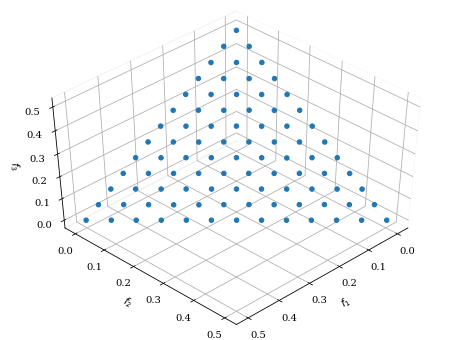

In [39]:
from pymoo.algorithms.nsga3 import NSGA3
from pymoo.factory import get_problem, get_reference_directions
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

# create the reference directions to be used for the optimization
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)

# create the algorithm object
algorithm = NSGA3(pop_size=92,
                  ref_dirs=ref_dirs)

# execute the optimization
res = minimize(get_problem("dtlz1"),
               algorithm,
               seed=1,
               termination=('n_gen', 600))

Scatter().add(res.F).show()

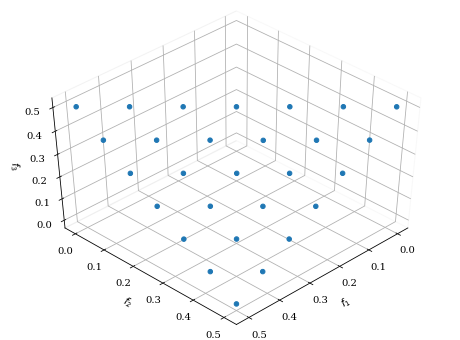

In [40]:
res = minimize(get_problem("dtlz1^-1"),
               algorithm,
               seed=1,
               termination=('n_gen', 600))

Scatter().add(res.F).show()

##### Riesz s-Energy

In [4]:
from pymoo.factory import get_visualization, get_reference_directions
from pymoo.util.ref_dirs.energy import RieszEnergyReferenceDirectionFactory

ref_dirs = get_reference_directions("energy", 3, 90, seed=1)
#get_visualization("scatter").add(ref_dirs).show()

In [5]:
ref_dirs = get_reference_directions("energy", 3, 250, seed=1)
#get_visualization("scatter").add(ref_dirs).show()

#### Das-Dennis
n_partitions
\begin{align}
n = C_{p}^{M+p-1} \\
\end{align}
n = number of points

p = number of parameters

M = number of objectives

EXAMPLE:
\begin{align}
p = 10 \\
M = 3 \\
C_{10}^{3+10-1} = \binom{10}{12} = 66 \\
\end{align}

Interior Points
\begin{align}
n_{I} = interior points \\
n_{I} = \binom{p-1}{p-M} \\
\end{align}

In [6]:
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)
#get_visualization("scatter").add(ref_dirs).show()

Text(0.5, 0, 'Dimension')

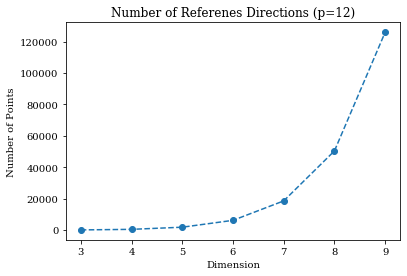

In [7]:
import matplotlib.pyplot as plt

n_dim = range(3,10)
n_points = [len(get_reference_directions("das-dennis", d, n_partitions=12)) for d in n_dim]

plt.plot(n_dim, n_points, '--o')
plt.title("Number of Referenes Directions (p=12)")
plt.ylabel("Number of Points")
plt.xlabel("Dimension")
#plt.show()

#### Multi-layer Approach
bias towards the center

In [8]:
ref_dirs = get_reference_directions(
    "multi-layer",
    get_reference_directions("das-dennis", 3, n_partitions=12, scaling=1.0),
    get_reference_directions("das-dennis", 3, n_partitions=12, scaling=0.5)
)

#get_visualization("scatter").add(ref_dirs).show()

In [9]:
ref_dirs = get_reference_directions(
    "multi-layer",
    get_reference_directions("das-dennis", 8, n_partitions=3, scaling=1.0),
    get_reference_directions("das-dennis", 8, n_partitions=2, scaling=0.5),
)

#get_visualization("pcp").add(ref_dirs).show()

No scaling 
Riesz s-Energy method to optimize 
not reference directions directly by scaling

In [10]:
partitions = [3, 2, 1, 1]

ref_dirs = get_reference_directions("layer-energy", 8, partitions)
#get_visualization("pcp").add(ref_dirs).show()

In [11]:
from pymoo.util.ref_dirs.energy_layer import LayerwiseRieszEnergyReferenceDirectionFactory

fac = LayerwiseRieszEnergyReferenceDirectionFactory(8, partitions)
ref_dirs = fac.do()

#list(fac.scalings)

In [12]:
ref_dirs = get_reference_directions("layer-energy", 3, [9, 5, 2, 1])
#get_visualization("scatter").add(ref_dirs).show()

#### Compare NSGA-III to U-NSGA-III

In [13]:
import numpy as np

from pymoo.algorithms.nsga3 import NSGA3
from pymoo.algorithms.unsga3 import UNSGA3
from pymoo.factory import get_problem
from pymoo.optimize import minimize

problem = get_problem("ackley", n_var=30)

# create the reference directions to be used for the optimization - just a single one here
ref_dirs = np.array([[1.0]])

# create the algorithm object
algorithm = UNSGA3(ref_dirs, pop_size=100)

# execute the optimization
res = minimize(problem,
               algorithm,
               termination=('n_gen', 150),
               save_history=True,
               seed=1)

#print("UNSGA3: Best solution found: \nX = %s\nF = %s" % (res.X, res.F))

In [14]:
_res = minimize(problem,
                NSGA3(ref_dirs, pop_size=100),
                termination=('n_gen', 150),
                save_history=True,
                seed=1)
#print("NSGA3: Best solution found: \nX = %s\nF = %s" % (res.X, res.F))

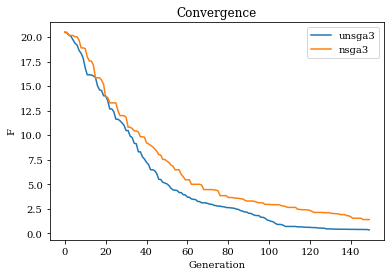

In [15]:
import numpy as np
import matplotlib.pyplot as plt

ret = [np.min(e.pop.get("F")) for e in res.history]
_ret = [np.min(e.pop.get("F")) for e in _res.history]

plt.plot(np.arange(len(ret)), ret, label="unsga3")
plt.plot(np.arange(len(_ret)), _ret, label="nsga3")
plt.title("Convergence")
plt.xlabel("Generation")
plt.ylabel("F")
plt.legend()
#plt.show()

#### R-NSGA-II

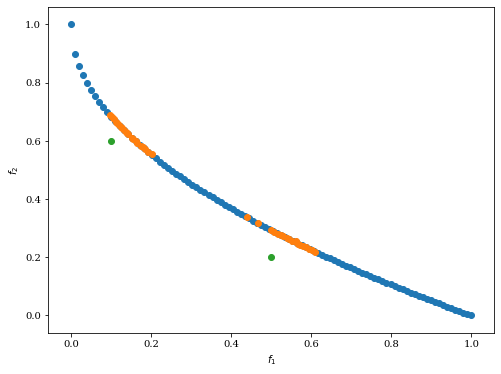

In [16]:
import numpy as np

from pymoo.algorithms.rnsga2 import RNSGA2
from pymoo.factory import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

problem = get_problem("zdt1", n_var=30)
pf = problem.pareto_front()

# Define reference points
ref_points = np.array([[0.5, 0.2], [0.1, 0.6]])

# Get Algorithm
algorithm = RNSGA2(
    ref_points=ref_points,
    pop_size=40,
    epsilon=0.01,
    normalization='front',
    extreme_points_as_reference_points=False,
    weights=np.array([0.5, 0.5]))

res = minimize(problem,
               algorithm,
               save_history=True,
               termination=('n_gen', 250),
               seed=1,
               pf=pf,
               disp=False)


Scatter().add(pf, label="pf").add(res.F, label="F").add(ref_points, label="ref_points").show()

# Paper Problem Example 

In [17]:
import autograd.numpy as anp
from pymoo.model.problem import Problem
class MyProblem (Problem):
    def __init__ (self):
        super().__init__(n_var=2,
                         n_obj=2,
                         n_constr=2,
                         xl=anp.array([-2,-2]),
                         xu=anp.array([2,2]))

    def _evaluate(self,x,out,*args,**kwargs):
        f1 = x[:,0]**2 + x[:,1]**2
        f2 = (x[:,0]*1)**2 + x[:,1]**2
        g1 = 2*( x[:,0]-0.1)*(x[:,0]-0.9) / 0.18
        g2 = -20*(x[:,0]*0.4)*(x[:,0]*0.6) / 4.8
        
        out["F"] = anp.column_stack([f1,f2])
        out["G"] = anp.column_stack([g1,g2])

In [18]:
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation

algorithm = NSGA2(
    pop_size=40 ,
    n_offsprings=10 ,
    sampling= get_sampling("real_random") ,
    crossover = get_crossover("real_sbx", prob=0.9, 
                              eta=15) ,
    mutation=get_mutation("real_pm", eta=20) ,
    eliminate_duplicates=True
)

In [27]:
from pymoo.optimize import minimize

res = minimize( MyProblem() ,
               algorithm ,
               ('n_gen', 40),
               seed=1 ,
               verbose=False )

### Gradient

In [23]:
F, dF = problem.evaluate(np.array([0.1, 0.2]) ,
                         return_values_of =["F", "dF"])
print(F)
print(dF)

AttributeError: 'NoneType' object has no attribute 'print'